In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cvxpy import Minimize, norm1, Variable, norm, Problem, SCS
%matplotlib inline

$$min_{\tilde{\beta} \in \mathbb{R}^p} \vert \vert \tilde{\beta} \vert \vert_{l_1}$$

subject to 

$$ \vert \vert X^T r \vert \vert _{l\infty}  \leq (1+t^{-1}) \sqrt{2 \log p} \cdot \sigma$$

In [92]:
def create_experiment(n, p, noise_s, S):
    X = np.random.normal(0, 1, n * p).reshape((n, p))
    # renormalize the columns of X
    X = X / np.sqrt((X**2).sum(axis=0))

    # the real beta
    beta_true = np.zeros(p)
    random_indices = np.random.choice(range(p), replace=False, size=S)
    beta_true[random_indices] = (
        np.random.choice((-1, 1), size=S) * (1 + np.abs(np.random.normal(0, 1, S))))

    noise = np.random.normal(0, noise_s, n)

    # compute y from X and beta, return true beta
    y = X.dot(beta_true) + noise
    return X, y, beta_true

In [6]:
def solve_experiment(X, y, noise_s, t):
    # recover n and p from the shape of X
    n, p = X.shape

    # define and solve using cvxpy
    beta = Variable(p)
    obj = Minimize(norm1(beta))
    constraints = [norm(X.T * (y - X * beta), 'inf') <= (1 + 1/t) * np.sqrt(2 * np.log(p)) * noise_s]
    prob = Problem(obj, constraints)
    prob.solve(solver=SCS)
    return np.array(beta.value).reshape(-1)

## two stage solving

In [7]:
def two_stage_solve(X, beta, noise_s, alpha=1e-1):
    # use beta only to find the right indices
    indices = np.abs(beta) > alpha * noise_s
    X_i = X[:, indices]
    
    # get the true solution on beta_I, the rest are zeros
    beta_i = np.linalg.solve(X_i.T.dot(X_i), X_i.T.dot(y))
    beta = np.zeros(X.shape[1])
    beta[indices] = beta_i
    return beta

In [8]:
def plot_exp(beta_true, beta, beta_two=None):
    """Plot an experiment"""
    if beta_two is not None:
        plt.plot(range(p), beta_true, "o", range(p), beta, "+", range(p), beta_two, '+')
    else:
        plt.plot(range(p), beta_true, "o", range(p), beta, "+")

### compute errors

In [42]:
def error_ratio(beta, beta_true, noise_s):
    true_error = ((beta - beta_true)**2).sum()
    min_beta_noise = noise_s * np.ones(beta.shape[0])
    indices_where_beta_smaller = np.abs(beta) < noise_s
    min_beta_noise[indices_where_beta_smaller] = beta[indices_where_beta_smaller]
    ideal_error = (min_beta_noise**2).sum()
    return true_error / ideal_error

In [85]:
n = 72
p = 256
S = 8
t = 1e-1
noise_s = 0.33 * np.sqrt(S / n)
alpha = 1e-1
noise_s

0.11

In [86]:
X, y, beta_true = create_experiment(n, p, noise_s, S)
beta = solve_experiment(X, y, noise_s, t=5)
beta_two = two_stage_solve(X, beta, noise_s, alpha)

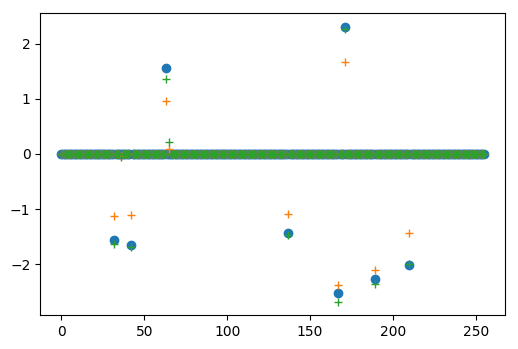

In [87]:
plot_exp(beta_true, beta, beta_two)

### run 500 experiments

In [29]:
import time

In [31]:
t = time.time()

In [34]:
time.time() - t

24.291521072387695

In [41]:
for i in range(1000):
    t = time.time()
    X, y, beta_true = create_experiment(n, p, X_s, beta_s, noise_s, S)
    beta = solve_experiment(X, y, noise_s, t=100)
    beta_two = two_stage_solve(X, beta, noise_s, alpha)
    ratio_ds = error_ratio(beta, beta_true, noise_s)
    ratio_gd = error_ratio(beta_two, beta_true, noise_s)
    print("ratio_ds={} ratio_gd={} in {} seconds".format(ratio_ds, ratio_gd, time.time() - t))
    ratios_ds.append(ratio_ds)
    ratios_gd.append(ratio_gd)

ratio=16.912208446853356 in 260.0478820800781 seconds
ratio=19.43693738911309 in 299.47651505470276 seconds
ratio=17.331328106471535 in 173.46966791152954 seconds
ratio=19.950767923104806 in 186.5260410308838 seconds
ratio=19.65503422937462 in 265.8314139842987 seconds
ratio=6.421439000156245 in 198.27885389328003 seconds
ratio=6.604673548303492 in 131.29301810264587 seconds
ratio=16.19960832152217 in 129.12431979179382 seconds
ratio=11.279348732316564 in 208.37288999557495 seconds
ratio=9.394546472768678 in 133.4028308391571 seconds


### exp results

In [68]:
ratio_gd = [2.349097878324955, 3.5637680471034057, 3.4167484516606863, 1.6977255262422588, 1.2634355222706588, 2.0934977241664448, 2.8911975157561987, 4.796358566811205, 0.9017127275771412, 3.039396397254156, 0.3226209123530849, 2.084176313970136, 2.3907509100557305, 2.7134651086488404, 3.2232576993080055, 1.1982680065099547, 1.8077550697306695, 12.854098749284852, 1.5981819874430052, 1.5817496044153618, 1.8642964759212894, 2.8565859104543048, 1.6491614265648153, 1.705370930759763, 1.9955214623985085, 2.7718845549704403, 2.1371056952774916, 2.0814856780981406, 2.0844449919140695, 1.4016870603899647, 4.083037179536388, 3.2151206627542694, 2.2302644194338828, 2.0363275643648717, 5.4538886137143345, 3.520083214893022, 1.4981494459977138, 4.032168651523373, 1.7318178151799355, 2.921144508115961, 1.7493116979784777, 1.5001206836810042, 1.6262601313009584, 2.4797771870203023, 2.767348695830932, 4.6248604379154585, 15.588217512826647, 3.880897539273778, 1.6097201940422765, 2.082775832354458, 0.8499926665461826, 3.801082730571411, 4.977695914528679, 3.3730911315593217, 1.7020618508660632, 3.1713098276690426, 1.6675683997487447, 2.1851246709561516, 1.1771149851637648, 1.0927387174569978, 1.12075095688187, 2.868637214667501, 2.6437700769228156, 1.6583970250949722, 1.6336366905290658, 1.265662399825481, 1.2467943872053018, 2.602505043329006, 4.249150511376075, 1.2129909221775081, 3.684484460000317, 1.2763777460053283, 2.217953079887156, 1.9019749946098587, 1.218354671467218, 7.106405563051273, 1.1176235364884637, 1.4667441845303406, 1.6292826215866487, 1.9389670580994844, 1.5107650258605552, 3.8790017689730067, 1.7475921767014517, 2.3520554350220126, 1.2274465521826228, 1.7347548960742243, 2.8139450339072476, 0.9504490944329914, 3.352598173299749, 3.2546856533181643, 1.496182816231263, 1.8387208533043293, 4.570839836856659, 2.138926284778129, 1.9996324950200375, 1.8740265890991294, 26.34927039026235, 0.2708632785487275, 1.354845303182375, 1.4851211313979074, 1.986556512036916, 2.767779619987023, 5.294262489097583, 1.5507434662962682, 2.536006522472418, 2.7988592600754574, 14.296460889547388, 16.263654098831953, 3.2753479870204045, 2.384239078201956, 5.081108075761828, 0.8112782497774441, 3.795352446376129, 5.796578330956571, 0.8966399893482316, 1.8546624151160773, 1.2054626173532346, 2.3028809000022523, 2.7969289007150975, 1.6704130114340536, 2.5657096911904684, 4.655994702622256, 2.2449644586747404, 15.328231302236823, 2.083185021803166, 2.7332124512144564, 1.7103173790943065, 0.8850145720802591, 2.051765435418639, 2.2138454376652072, 1.6669074689256724, 2.4152861332002584, 4.440077529226818, 2.8306597034021115, 3.3216640112315736, 2.5196010916486937, 12.663554397956032, 2.1768769089121736, 1.9574370469019757, 0.8040089773597469, 2.1320686796319475, 4.057811407248026, 1.9487197934320935, 1.6613014955473833, 3.128319873093215, 2.995982263517295, 1.6803062380418652, 1.2314592361622991, 2.5662597164992778, 2.45492694702178, 6.081561603267527, 3.4464388608589522, 3.1530806588251767, 1.8348922220789168, 3.2872192028604186, 1.2673581949961037, 3.6381111001389743, 2.0615958684425144, 3.126138265907177, 3.8386565043746432, 1.304851513058588, 2.803320404844252, 1.6508368147440171, 1.1640332649912077, 1.6590385594051338, 1.8479220940166963, 2.35552529346109, 2.4856884023284014, 2.1360283220050764, 0.7740589292940493, 4.877562932197897, 4.003610703173, 1.6264356901975676, 1.7737178167261582, 1.3742534480727147, 1.268996441707089, 1.6517341519992863, 1.6546909989845373, 2.798048455660168, 2.415324069150272, 3.47527353496317, 2.3535035480412945, 0.988901838970798, 1.8852063828310992, 2.312380989683402, 2.17099728051334, 3.5228492101461555, 2.0546571903156208, 1.8362443462639433, 1.5133204565551077, 2.2543004267473727, 1.9320576430770025, 1.252258081741466, 2.497551185137584, 1.7904374413560757, 2.032725232731794, 17.52971168215478, 0.8605529233501117, 2.2972554907304867, 2.9871014232063686, 2.326661759559222, 1.8088509525124907, 4.790468906956574, 3.2644639503123076, 3.281395622586509, 3.6269585342055066, 4.009078727166024, 1.9802188361260409, 3.9481857513457568, 1.9739134385428192, 1.8987563006930095, 1.372267493664375, 2.1369595423736776, 1.2823098387323772, 0.8265571824719975, 2.3587737466517793, 0.8776625514990664, 2.583980589424151, 0.9054691731364486, 2.780858690202605, 1.6094426636900694, 1.4524486688619864, 1.465457721912665, 2.1803337763948942, 1.9283327169137112, 2.369817192561099, 1.5455401552128394, 1.2400175388788812, 6.013272195157923, 14.387661824228555, 3.5051099264418664, 1.043404937184799, 2.7348347755169296, 1.243596293598547, 2.0278476320625045, 4.256348121976675, 2.4791172595236497, 1.7954821311737679, 1.7206325116709371, 18.211059114245632, 1.3787123275148052, 2.533873105254666, 5.564689215797847, 3.225697172165659, 1.6258485024608142, 2.720781097263249, 2.047785625739963, 1.8583247615991716, 3.7048096889810713, 1.4171610805741992, 2.111527131792458, 3.224823673631272, 2.3826645957367067, 2.5865136680894247, 2.014316009355088, 3.414083548065714, 1.819666528704366, 2.0567137036442826, 2.3614187873153054, 1.8148299576227462, 0.35769973158715324, 1.3978226917456285, 2.095378095590852, 1.6828449902471674, 2.5462518298605703, 0.8190441305710752, 1.0876793884741591, 2.258176952073807, 1.5986896246960787, 2.0477163484699825, 2.5881417483178835, 2.2308711125967475, 2.047190232977826, 3.181985249934131, 4.902187133387569, 1.3239003863706293, 6.20537435115595, 2.7785705025349423, 2.4038025371160896, 6.306273425274147, 3.262817066151567, 2.3442125331731876, 2.0263975325315937, 2.340954766553607, 1.374634713281672, 3.9780151025955157, 4.181816264908466, 2.0758455778445892, 3.482736488534807, 14.533467330484171, 6.8082002456203545, 1.8591808994612562, ]

In [69]:
ratio_ds = [36.37874197658395, 21.9334520209888, 11.527236584095318, 24.291105492201783, 12.79492643391758, 12.161920727560522, 25.243864740954773, 34.86184032622521, 13.601606157559305, 38.72188756307922, 13.602725190759944, 16.797767610776827, 18.205154888027455, 23.61112970349269, 15.19177815909804, 36.72025519493313, 14.159300539631827, 24.916447027511293, 24.128885647299054, 19.44686445168202, 10.240986278939323, 20.488831202964185, 12.974497777563313, 16.404209162535658, 24.03911393280833, 18.465852256139936, 27.01267600078861, 15.674739743625418, 45.42776274602521, 43.104525048546236, 11.09612510250164, 10.564921461167403, 9.43463235577296, 18.700257402148228, 22.03737365262425, 32.590431422136106, 9.612116005880129, 27.682722649119533, 16.72323999890105, 19.600020260252453, 27.36459810807822, 13.864301676061825, 8.143677546350531, 11.834757242114554, 17.272131129120904, 25.853206322946633, 38.483529219638825, 21.356558485861395, 21.46127639552799, 10.060037882071253, 14.575628205495201, 8.730104821126565, 40.656941243349955, 8.897352391511616, 28.41313202075332, 17.11869929918087, 36.11660358176613, 9.610227943343013, 10.76270557115413, 11.050772629593995, 4.632966798921188, 20.241947540908782, 18.064789150241367, 17.431573204661227, 25.798547073302455, 59.83481266978365, 7.26400000604154, 30.401742771460565, 11.46252038859905, 16.759027071355447, 9.295757178076174, 19.363484619726695, 9.569418536022436, 18.40671118577264, 16.989442797393348, 44.662217928748824, 20.742587111722, 14.09960158302748, 7.9812509858239045, 13.558627773553463, 15.565111033157114, 27.02007218366164, 16.473664606199353, 9.777525347930679, 13.553326186456426, 17.898229015342345, 27.13506819680987, 12.208330645608303, 22.725233172037143, 19.346878628841715, 5.5286362968623, 18.57605249721445, 24.56494576295786, 15.377132948767914, 10.074163451195483, 31.702693975280177, 46.12986111617328, 8.432531296389962, 16.899900042580764, 12.16916167679262, 18.39654073842319, 24.315769907805176, 41.44611765180695, 13.529859279450708, 20.36303591237487, 19.035504709498934, 34.83730348207515, 32.91451978280897, 15.295946040940114, 12.305462472377398, 15.901745055337718, 11.996690009639922, 17.22993762400471, 35.75728561458747, 11.19059077030821, 23.62797532729095, 28.278772494686603, 11.512952153834787, 15.741716416809204, 24.138542581470062, 7.731593868032132, 24.48558587544558, 15.161578362186523, 36.00044957899494, 14.08673311598448, 32.7463076828383, 35.49149339225644, 9.20720281666818, 17.485354276239352, 10.89031118305519, 10.161590610981353, 11.388151782945116, 12.423382613777964, 13.022369888273014, 26.341859583725935, 13.741912049003655, 27.370184192189942, 19.0313050840864, 14.723895786774372, 17.582696527483954, 32.300682255854014, 17.338309386466936, 15.114390759264516, 11.846909842014727, 18.180449498798918, 21.41551431067745, 13.660568119365323, 22.53746174013814, 14.73118057075313, 15.49694425801832, 30.111182907513335, 18.9811160068401, 20.48908279564533, 21.33227233239818, 8.901205871420059, 16.98670978090127, 19.07851959585362, 13.267820361852037, 11.994166643008132, 14.96592193039025, 25.847852538830928, 20.33602077614874, 12.80960452131812, 12.350974289357474, 36.297395659342584, 11.415911070328375, 20.227339433154164, 25.806244943201666, 15.255305675284973, 22.74080734084948, 21.280856715989692, 13.127576612152552, 19.629015673993536, 12.37986761773493, 37.58864528078534, 12.979863561074641, 17.97613748768745, 20.74859130994685, 20.270371297788046, 15.932293978556464, 23.134862296236967, 19.099450855084644, 12.93076295092875, 10.236692982171833, 16.997886948406876, 34.25217475757977, 30.022776012672313, 40.00035683051544, 14.039248037713381, 8.167419546421863, 16.12173505975831, 23.02913265750285, 42.92874985412882, 15.754782845224831, 21.355166237723353, 12.572174956049642, 57.54288564855109, 12.85988385804815, 12.298117456600508, 17.491585991765632, 8.805147998311392, 22.861677136207213, 13.914970902101302, 15.587633096109412, 23.528994334783526, 8.19730671001454, 32.98723806348529, 8.02060568097072, 16.113582016473792, 15.159362062340339, 14.461554324870665, 20.212009662059096, 43.28939590061054, 16.212472097799324, 9.721397528065427, 14.761901505491695, 20.461695288062028, 7.172293156799157, 9.24357570965362, 33.09980101857904, 15.282069398923857, 15.732192770306364, 17.691336668984764, 11.461811972017234, 13.9544314126051, 12.979676636892945, 23.09421789284662, 24.734659846542865, 30.493881007342452, 36.724230868890515, 11.467989118277945, 21.786542690309144, 14.197509236139274, 11.42466472163306, 14.149606484564437, 20.453050891418307, 18.35275813138713, 13.484566063819587, 13.294982816052185, 38.24139980675045, 30.096660306219256, 15.051665434785077, 34.669320062538986, 11.815047853509526, 14.681553902468268, 12.087403697634059, 17.03644279137485, 38.7645257142822, 38.47767803426172, 14.626335619498848, 17.653805762277834, 38.98548573183603, 8.027065456503847, 8.132907101959859, 18.91666757073004, 26.675342247979163, 16.237043353383267, 14.241525295038276, 23.209775688364985, 15.51629125045025, 8.479830150298092, 14.164557404155442, 13.708577951049373, 13.737069298829956, 23.892112607778753, 14.80426383563984, 12.928053687522603, 31.474392166497353, 25.007878660748283, 18.637259542005577, 13.134756105166398, 17.04296920343349, 18.141858411619687, 11.618113193302797, 22.06932730777089, 14.622744298234183, 31.58392616229212, 19.090994113129906, 28.79824494956408, 20.931162304016983, 25.376409042790822, 16.159650006673125, 10.135592025605261, 24.698895023037387, 14.367489402021505, 27.7684220948746, 20.95178807280932, 18.892575178070445, 39.82821049297229, 26.94342387234817, 48.47071567316584, 34.11395536531532, ]

In [88]:
ratios_ds = [17.4072539655, 15.355307032, 22.9790335806, 27.7172042845, 9.57449159915, 20.8484522825, 18.8192362079, 25.0130210165, 22.6326520377, 8.5029985997, 10.8134727053, 31.7369045027, 14.103049002, 14.4959441534, 14.9399410044, 15.36698232, 10.9322941964, 28.976610659, 49.5952307075, 15.7040799188, 13.339407161, 22.5520011055, 11.1091792586, 16.3681874599, 18.1658282279, 17.6571058965, 26.6188874062, 17.2071019765, 28.1359537398, 14.1271196355, 21.4490630188, 18.9771113397, 23.9571281556, 14.8702536651, 10.2384240097, 22.8736865269, 13.0440574289, 17.3378248147, 22.2812785724, 10.6396156116, 18.5105075909, 14.6123263717, 22.1676458585, 51.6883065133, 11.2916043817, 16.8004850425, 10.4268114094, 8.82860337007, 17.3031201402, 13.323116549, 20.475247757, 47.9022343191, 21.8670296395, 17.0775604916, 51.0671829234, 8.8099638251, 12.5589221173, 11.5429986811, 19.7864373514, 11.7192853075, 16.2906033196, 33.7960989086, 10.9906635362, 12.0258512591, 23.7407917242, 8.29639219457, 10.9463229866, 14.6323050746, 24.4714651964, 20.0995240367, 26.2440455621, 9.32350995409, 18.9364485016, 10.9667421972, 9.99466070777, 17.9583719243, 10.81325378, 58.5273053918, 11.7055127754, 11.4655063262, 30.3499038837, 31.025070812, 10.2023540671, 17.2273121474, 38.8644563037, 17.0057352565, 19.2522266785, 20.6765604425, 19.08048191, 22.4257051726, 23.0186631428, 26.5561645041, 12.3807879034, 19.3851624969, 20.3339426478, 11.6283109182, 20.2664269925, 8.38235432506, 7.66840789231, 15.1763451502, 12.8352470917, 12.3884577075, 35.2315768593, 12.3770078277, 21.9946582189, 14.3646918867, 16.1798347825, 11.9507845068, 26.4486748699, 18.4347214248, 17.0084093421, 24.3790293616, 12.7620167323, 55.3142621739, 21.0292976148, 15.9020042023, 15.884084319, 21.8401998541, 8.62944184042, 14.1798752636, 29.6096409557, 11.3449289077, 73.1862260974, 16.6241062168, 17.5589274805, 23.5466099464, 21.6802067966, 26.05929756, 13.0203550562, 20.2521815718, 15.9048983971, 14.0945957181, 8.5339832395, 26.502927814, 27.759473548, 21.254555805, 29.7884583855, 14.5568170934, 9.76935150221, 15.2527098779, 18.972456263, 15.1837567414, 27.9222563084, 22.3862430753, 21.6618975897, 50.7662346989, 12.6772163938, 11.3233840183, 16.3968185664, 13.8489576777, 28.2153192289, 15.1645775044, 26.5253456646, 9.03041307432, 10.5160902839, 13.6703417086, 29.1677828774, 9.31805419104, 47.5600264604, 19.7928778154, 39.0012016818, 33.0961525323, 8.49599580479, 21.5577160107, 9.21603485076, 16.6661306311, 23.2612611013, 12.6883114056, 27.3443602031, 11.7043117041, 17.0034814526, 19.966736933, 18.1611549158, 16.2854317912, 16.0739092313, 13.8496128623, 12.7767418958, 19.7952719903, 30.8524419229, 7.92605511542, 26.4346228361, 15.8618092094, 9.58910130638, 16.2844614593, 23.0944283739, 21.4073474877, 8.41150242343, 8.6316193535, 34.7111841243, 19.8768167147, 24.1084163181, 16.9419177807, 14.9813473679, 19.9828522634, 19.8429620979, 24.4474379439, 20.3150758929, 13.7919974211, 18.1814978765, 34.3633290658, 14.1479693748, 13.7705294964, 20.7628356343, 36.5626246223, 12.3022639917, 19.1981907065, 16.5148237469, 10.8653011608, 18.5322498659, 18.7125269513, 10.5163834099, 10.855782105, 18.760192003, 43.3575187534, 22.2889182247, 9.08987087906, 11.1498724993, 22.8979225893, 14.0842740334, 18.1659086225, 7.82391714346, 23.4903581859, 24.821328524, 15.0724002797, 24.8601457997, 18.2516497518, 9.2659540955, 10.2333309952, 6.48649799455, 42.5886367276, 18.1961850646, 18.8144027291, 13.0081693219, 39.3276116711, 62.4381949349, 45.5516702047, 14.5113716797, 18.3981663917, 15.1792736548, 10.5580588086, 26.9513570684, 22.7302195017, 20.4363118982, 26.3452529012, 15.8390836097, 29.0976962418, 14.3650777182, 25.5151778428, 19.836161552, 15.436234446, 21.0698954924, 15.2052356658, 15.7663078349, 23.9789412976, 15.421307934, 33.2990241141, 14.6413800683, 30.7608130331, 28.5592032131, 14.7444166039, 13.8141693193, 13.2191425154, 25.1027533072, 12.9890081477, 30.8915330161, 8.8501708702, 21.8020315666, 12.3486993673, 17.521900157, 15.9677706871, 13.2231778817, 16.6588917288, 11.6252614515, 31.0181325292, 24.4846695059, 23.2790833401, 8.59478144996, 17.0108548652, 12.8379025663, 60.5849142508, 22.6620760932, 42.9242871458, 13.5930747634, 23.6915288115, 11.9978272869, 25.9876397778, 9.75004670554, 5.79244677179, 14.3415363869, 14.8787978513, 18.4648152839, 17.5516927162, 13.6014950617, 22.8737914222, 9.33532856535, 15.6673811741, 29.3694655823, 13.4139763172, 17.8953604407, 21.4280545746, 16.7037111748, 23.883556868, 10.0272769014, 20.8426031109, 14.1818124692, 22.6666672577, 7.3969506396, 17.6778166633, 19.7190185209, 36.5532298008, 13.8005772316, 18.3840884929, 6.55692353792, 23.7967610095, 17.0406655919, 14.0092865732, 21.0864751313, 28.4654065099, 53.0628226187, 18.1828341412, 16.313242861, 12.628587724, 7.71030215298, 14.9317730065, 15.0841392386, 31.4447089748, 6.80538128514, 18.5979593923, 15.7531691359, 11.7162209544, 11.8689217718, 12.8800155123, 9.87673612704, 10.7948417073, 28.1706434309, 16.9071892426, 11.8590162946, 19.4716373872, 30.881544583, 23.2049071649, 20.8107416348, 15.4000523786, 21.6399640033, 18.5917615161, 12.5523857687, 12.0969772115, 37.1816977163, 9.92319498414, 19.549253945, 23.4727248707, 27.8161673575, 20.706373777, 35.0853085201, 16.1959859896, 19.1194738957, 18.6078821212, 10.5329791242, 21.0989710642, 17.9574377215, 9.68383168426, 10.4404376567, 20.6823326249, 15.9683204486, 12.4915326042, 12.851484077, 13.5828257439, 18.5838193279, 14.4364016555, 23.5693188098, 24.3620724756, 31.9861020737, 11.9744653333, 21.7658495312, 12.2651841073, 9.04139321791, 20.9326735712, 19.9898210009, 30.6607965104, 10.0941619437, 11.8584373727, 12.0473230956, 16.4372778353, 9.01559215304, 18.680744964, 15.0397538528, 25.4126268987, 21.2138097087, 19.1330732535, 24.2007998275, 15.3429603869, 12.5766793115, 16.4975187932, 15.8215799945, 30.9572447122, 12.3378302679, 19.9761820071, 22.0046122169, 24.0621018829, 14.8280621317, 12.7364640421, 14.7745474415, 16.3449699144, 11.3103173011, 17.069376116, 47.674713365, 18.5198480114, 17.8754890644, 13.2787972387, 13.846517376, 29.0243703993, 9.58963555627, 13.5564423849, 15.4294281367, 46.6375888472, 39.617309713, 11.5324522747, 38.0949228551, 20.2053313526, 29.8694695074, 25.9703499063, 17.3034000562, 18.9202290588, 28.4609995454, 25.1156833376, 19.1609138526, 18.1507237851, 10.9247923913, 18.4479987058, 21.4458598354, 26.5509282097, 17.0951919598, 14.8595055368, 10.863785594, 29.1293899505, 15.2188979112, 31.2962641236, 34.7321124132, 24.6846370988, 23.4581825037, 31.6497694826, 17.3556788748, 26.9907117198, 14.218847796, 41.1798562244, 17.4654713733, 10.8055397113, 24.4200663095, 11.8349700745, 27.1433349439, 9.79604058914, 42.4999687454, 12.7979357852, 15.8140243333, 10.0391933216, 9.45158293131, 17.4745498919, 19.3397419366, 20.449712884, 22.4863043369, 14.8611411409, 14.0641923481, 17.6380195036, 13.2513435514, 7.66106186556, 24.8479389128, 12.5732771701, 31.1459762822, 18.2598699674, 25.1462859985, 30.4647967063, 14.9732789568, 22.7226887331, 30.8940016079, 14.5347015287, 43.1123331076, 17.1103459098, 19.3205544902, 18.7382919218, 40.1187432008, 25.8166492951, 18.6111951052, 15.7514870702, 21.0791071791, 29.6791379505, 18.040409409, 11.8168942494, 10.4184107004, 9.66072625435, 20.0718440821, 19.453817044, 7.77238043486, 30.0244009974, 54.0371103663, 33.3286870635, 12.3290593175, 15.4874709643, 22.217999822, 13.1820229995, 22.4446712366, 19.5326253781, 39.6126362021, 40.6389706332, 8.82559261725, 12.6183058917, 21.4736668269, 18.6450005003, 18.3681011889, 25.8325288308, 17.6469123866, 9.61458972029, 12.0856145087, 16.9662449595, 7.64169109305, 16.9254681563, 20.2293378908, 39.6053809907, 24.2932327909, 9.82766083323, 14.6095629486, 28.3982103513, 17.877207131, 15.837397687, 19.1066320698, 14.9301911115, 18.6169033925, 13.1792768398, 14.704766912, 12.1299585217, 16.614126267, 45.5034698137, 15.1587912071, 17.1703074832, 13.7138072312, 18.3229194493, 16.9319900677, 20.9636811441, 30.8749863592, 18.8357524466, 25.3020809668, 17.9304225354, 6.18270021498, 13.2569726476, 8.14453999567, 12.5545690018, 12.0960748408, 34.121282921, 15.063650336, 17.891333361, 27.8434368908, 14.107323284, 13.7194031566, 12.3556895975, 25.1119479928, 21.1855915901, 24.606471626, 19.2626255116, 17.2883334126, 31.987635652, 13.2011080088, 32.6161904347, 38.672382348, 23.9243220152, 20.9209698218, 22.3216047761, 22.6987350894, 10.1067617435, 20.8585024305, 17.2977829133, 21.2132033223, 17.7640619224, 13.3368572292, 13.99494996, 26.2744589386, 10.5398694308, 30.7364720721, 36.7599956831, 27.3845061889, 26.2315573949, 11.2237824713, 26.2155983946, 21.0743679164, 7.16006529661, 11.7863777535, 18.1364281726, 8.16799239631, 16.1333128682, 21.4025091517, 18.068600977, 21.8504856539, 11.5913978092, 17.1405652651, 14.5936132737, 26.2540071369, 23.3716817999, 14.8165451968, 25.5642594969, 17.7286491117, 17.0422911937, 15.022217419, 11.6995187111, 32.6432381952, 14.5046920795, 14.0165109586, 10.8646913994, 20.3221727095, 15.8202923415, 13.3574346797, 16.1743718115, 23.3296357083, 34.1941159591, 13.8038630567, 11.9367105278, 15.6644606417, 22.4216377416, 11.7905343797, 8.50213891576, 30.7016761668, 14.687791338, 38.3925847728, 21.0403376423, 15.8674555304, 14.6159443495, 13.6048375022, 27.1359414959, 22.7446793761, 58.5623819976, 41.0270574634, 16.8486848083, 18.3612563866, 27.9285160157, 10.7065256752, 19.7375555103, 13.6821039424, 23.5679763184, 14.2259860246, 16.0988430619, 16.2858400125, 17.4031196202, 18.7607353762, 8.47352076175, 5.099408296, 40.929884223, 25.5045907527, 11.0418236389, 16.6207842548, 7.40626089773, 34.3522692928]

In [89]:
ratios_gd = [1.78408754672, 1.20532313614, 2.18621865704, 3.23121902017, 1.63372016977, 1.78959718155, 2.97068257051, 1.47768901283, 4.63339080707, 2.34932224054, 2.32833761581, 3.07713331634, 2.61363539517, 2.25691846146, 3.02716464383, 1.68503822423, 1.922373043, 3.34730933162, 13.0628263956, 2.93944877159, 2.59397267606, 4.15222786239, 5.21711683817, 1.55000985207, 1.60328405397, 2.95627269882, 3.07202715555, 2.40071473104, 1.96492137766, 3.44537022291, 2.36968236227, 4.56259156366, 12.4005860193, 2.27919330605, 2.71629485815, 4.09335448037, 2.19215368765, 4.22841810149, 3.05977637056, 1.49292252472, 2.2328163853, 1.23833467677, 1.37475203738, 22.2659102102, 3.04460728414, 2.16472634649, 2.48686801883, 4.38824454545, 5.19100117087, 2.07401497118, 2.39300431629, 24.9063623639, 3.25203975623, 4.25335899315, 3.69774841487, 0.958126849564, 3.06873903113, 1.66941609681, 3.22036312319, 3.26903845097, 1.44574561821, 14.1015651333, 2.08515549053, 1.63482254971, 3.54051307208, 3.61651164728, 1.17918760885, 1.1896896179, 1.16968376551, 3.32220671656, 2.12212351802, 2.22870044263, 3.86940846103, 2.90691467815, 3.72087374642, 1.00901426395, 0.774339164357, 3.66023201164, 1.79255538043, 0.58324138315, 3.50354457044, 22.3312544083, 1.77023206032, 1.02211455577, 2.20041892322, 3.58317192069, 2.82211182893, 1.41034800864, 1.75499339033, 3.30170070712, 1.65088180162, 1.97167151404, 2.79299881788, 2.09720021692, 1.64041498428, 1.08457786558, 2.30870377315, 2.83754972659, 3.20786763559, 3.95859812404, 2.83286764478, 2.22551512386, 1.37715938922, 2.7511205598, 2.4509463188, 2.91049170968, 3.61351181452, 2.84446206056, 2.76184126361, 1.24367570992, 2.42802447997, 2.6376200715, 1.25791528122, 5.48414423426, 1.69837629255, 3.67988036469, 0.952695464634, 2.51958080494, 0.839307977476, 2.03906477965, 5.37872320417, 1.15247015812, 5.86179716084, 1.96279198896, 2.36807476432, 2.87933485183, 1.37783110132, 4.131324236, 3.55059556914, 2.40123400669, 4.13618955032, 1.93251101624, 0.486074965168, 1.20099801596, 2.47883745926, 2.56519558323, 2.40531296309, 2.06378204191, 2.2384769328, 1.69922274089, 3.78286265659, 2.53055147098, 1.8674923383, 4.67580541326, 3.95551377697, 18.4610526282, 2.5580475612, 2.84518887951, 2.10589894018, 2.45446401262, 1.15416371811, 1.06228404804, 1.61715539074, 1.13213197877, 2.58182203772, 2.01270761615, 17.5163714037, 3.21773747239, 4.0983902656, 3.32236858065, 3.11664979207, 15.097945516, 3.49021571187, 2.39706793149, 2.69352026087, 2.3900514409, 1.00681271815, 1.37995507833, 1.55486200733, 1.29004650044, 1.69995368024, 2.00875384411, 2.46159772075, 2.29870751138, 1.40832274313, 1.90765257443, 2.02247054841, 6.11076114678, 1.28135556632, 1.1348103124, 4.44276389658, 1.33228016792, 2.21915311999, 1.79058331738, 2.15187845067, 2.14476414977, 2.50743129359, 2.17629931082, 4.10144117749, 1.03371095563, 3.90982101356, 2.0131728094, 1.59629791277, 1.82782353819, 2.04801579837, 1.52354031183, 1.65584440788, 4.76164112587, 3.12713099094, 1.5784244002, 1.7178839793, 1.84362403961, 0.901474718284, 16.2267676967, 2.0544728279, 1.66076601591, 4.7496915448, 1.50100364238, 3.88169434561, 5.37829075527, 3.02518084676, 1.74046724255, 1.45102754983, 20.808207948, 1.13418614909, 1.91482202034, 2.15300346323, 4.36204393521, 4.36433325526, 4.6993586701, 1.48044662412, 4.51147021763, 3.59823494929, 1.98262494719, 2.500400172, 1.22051833691, 2.24953762324, 1.63678925513, 3.27581718257, 14.0419305352, 2.42902664793, 2.85062910423, 1.57991393154, 1.4383066431, 2.55565309362, 2.36514744943, 2.58529460399, 5.00869949094, 2.62940321987, 3.4528498821, 2.55757726901, 1.79262210317, 2.31570222408, 2.56695279737, 2.84986433561, 1.20927825645, 1.4100622729, 1.98577949228, 2.28758039644, 2.51853782728, 3.19362521588, 2.73413056893, 2.46123117916, 1.4077338452, 2.18613687743, 2.95291126203, 1.87014222364, 0.954391592091, 1.83296198006, 1.82065047504, 3.01215961441, 1.28317600711, 1.13654173471, 2.06361277529, 1.42423640569, 1.94195801907, 6.98590312347, 2.89110957226, 2.53019653189, 2.16927913246, 1.17820403301, 2.76860898513, 1.96572659382, 4.53052518526, 1.61360084195, 1.82931818744, 3.24297319663, 1.5873585824, 1.44389628912, 3.37446058226, 2.1103748161, 11.7816157613, 2.40171573448, 2.80476699007, 2.77163172904, 2.79398055929, 0.303270074081, 1.73931622299, 1.58990083672, 1.01746314925, 2.31739300519, 1.33411275417, 2.73731925424, 2.48177564122, 1.18312834024, 2.7338760067, 2.81670276674, 3.57325561897, 2.24032645328, 2.4648715149, 2.93008696255, 1.73632933239, 2.50122869676, 3.32088384465, 4.10073053741, 5.53923466519, 2.8400364515, 3.30234496859, 2.28744154666, 3.45823100734, 0.770186284517, 3.45423428779, 3.03024378821, 2.20139966056, 2.77177264276, 1.77573401072, 4.53283139841, 1.56572130251, 28.7616662973, 2.43280643821, 3.10076043866, 2.84343693943, 2.11660090192, 1.55087423128, 1.61490804459, 2.26543040255, 1.7615769685, 2.63183529048, 2.36500263058, 4.44301372535, 2.05100446539, 2.41114187754, 2.65258733917, 1.34118256473, 1.88402462449, 4.70399806345, 2.00078668231, 1.37306234871, 5.77095302591, 4.9110797409, 1.90250251611, 3.40916123692, 1.82014196181, 1.75485775022, 2.91664077496, 2.73142469662, 2.5058108407, 2.78627139373, 3.87381922148, 2.85791771558, 1.77713450477, 2.65984390223, 3.49735198443, 2.14798014774, 3.75266912769, 1.97072440205, 2.04409308885, 2.80477045112, 3.35914697638, 3.19290361771, 1.6827160354, 3.41956642171, 1.89448504349, 2.99337619001, 2.14910911832, 2.48470375943, 2.81848236308, 1.09252316775, 2.76919123161, 1.51787279228, 1.24821994929, 4.44955970159, 3.82997059415, 1.07998788836, 2.33325285149, 2.06361653564, 5.77879406182, 3.07663894471, 0.504741293363, 2.37642956929, 1.45332171028, 3.10347381922, 0.955682914576, 2.80379013471, 2.60741738835, 2.82708913446, 3.49902650852, 3.52730446158, 4.36135096616, 2.87498594168, 2.16987221261, 2.08977788325, 0.949560672379, 1.97455898869, 1.16662571265, 3.42301596949, 1.61427888173, 3.03243846371, 1.32911014223, 2.19787331275, 3.10689361174, 2.68375099364, 2.60306014401, 2.01706504599, 16.0089670825, 2.01428990479, 2.64875388885, 2.44775512148, 0.946096065853, 3.4283947228, 2.02084214485, 0.911384397737, 3.16445595494, 2.07239106734, 11.126281958, 3.03350616607, 2.86617514903, 4.75196963896, 12.9615849122, 1.25470124026, 1.21593989879, 1.70816548501, 1.4874702839, 2.75278820579, 2.00537925251, 6.98687188347, 2.72336711998, 2.84002601983, 1.58753634681, 2.11981244997, 1.55176627475, 2.82035276017, 1.22844372159, 1.39607887588, 3.60304639296, 3.3040111833, 4.99508814364, 3.26557975272, 6.18156789683, 4.00260044803, 2.43636180285, 1.39388830445, 2.486347192, 11.9185916143, 1.61447226091, 2.12782263317, 2.45454862875, 1.26016946381, 1.87367112091, 1.98537559704, 4.06498560354, 0.874588395494, 2.13257632492, 3.59254405918, 2.51511610928, 1.5899605689, 1.36926724903, 2.99289093648, 2.12059516656, 2.32064489589, 2.89126822396, 3.60743353923, 1.84218171544, 1.59845757653, 4.61862853876, 4.53022490525, 3.22154314788, 2.12991685345, 3.06418011972, 3.56097058716, 2.5881226185, 2.03667817821, 2.9746827832, 1.98687853716, 15.8080497525, 3.70226916943, 4.5508078591, 1.99148341452, 1.74974373254, 3.28529646469, 3.81726276674, 4.10780667388, 2.49427553899, 3.13210319717, 3.62268474145, 2.87939850941, 2.79665564486, 1.99589946821, 1.1811719779, 4.10174925304, 3.90621097526, 3.57854531383, 15.3303589754, 12.7967339275, 3.31386322458, 2.44378101342, 1.85573257435, 2.08490371407, 3.45472999864, 2.75796259817, 18.4268927728, 3.35962207638, 1.2420449782, 2.24451958658, 2.07174171376, 3.0176111899, 1.16719666633, 1.5262111438, 2.88761058883, 1.47963858862, 3.61258601537, 3.01011533639, 1.68871512563, 3.51739178461, 2.14248382434, 1.66324063586, 2.77515160882, 1.77922275609, 1.90505617608, 15.4222954845, 2.89913559755, 2.99453786247, 2.16277650002, 2.07734705853, 2.93274953426, 1.53506604152, 1.32985239692, 0.925428090537, 1.69988458441, 2.59170988112, 3.09977911471, 1.91573209027, 3.98566973639, 1.4496348826, 2.04079080004, 1.52385464927, 2.40771714951, 0.734461531478, 3.25528484901, 0.964171833084, 0.152617896109, 5.43293802591, 4.15856293638, 1.30943724658, 2.47213397089, 3.41896297396, 1.3230233761, 2.40602986046, 3.40967417393, 2.53290598511, 2.13766441518, 1.6617467708, 2.60298751381, 2.1351925413, 3.02224620574, 3.16122055296, 1.2729843949, 17.7597901861, 3.13737662112, 2.60998355164, 18.9817244023, 3.16795660789, 1.75007393712, 1.45616333125, 3.17238331248, 0.837137741561, 2.37835978853, 2.87836716679, 3.1925946353, 1.12269502115, 3.5464120478, 2.34870310989, 2.3010815576, 2.00006185112, 2.74715295326, 2.76150891032, 4.04812476732, 2.11218943892, 3.75822408952, 2.8362438409, 2.23159898843, 1.09619799927, 0.739322023072, 2.60693875897, 2.5111821609, 1.753283546, 1.20502869236, 1.23094948998, 3.03384711886, 1.97278745548, 3.02276170631, 2.44849857693, 2.28249892445, 2.37373016077, 2.59113380065, 6.92850424889, 4.86862658392, 1.34829455143, 2.10561896823, 1.45345309114, 1.12004866504, 5.11194305271, 4.31011716929, 0.939955841402, 1.49798169185, 2.53567299806, 2.20294023843, 2.1400379619, 7.58395522365, 5.08045265367, 1.93684035564, 0.70809510467, 2.41361156306, 1.8868656931, 1.63879466446, 2.74582161125, 14.3860154717, 1.19445405371, 4.65799929153, 1.81395625606, 2.95817998346, 2.13745308097, 2.09667536936, 2.01805945511, 2.26574441876, 51.4333278201, 29.1454452083, 3.77052874968, 2.12813262254, 12.1371525123, 2.81088259659, 1.91290927239, 2.0210370498, 4.13344959132, 3.75718123303, 0.745811639926, 3.02926803687, 3.5278012047, 4.46349919334, 2.97114345556, 1.79361810922, 3.94361782168, 2.06576437608, 2.28225670256, 1.9880118736, 2.52921569905, 0.954245338949]

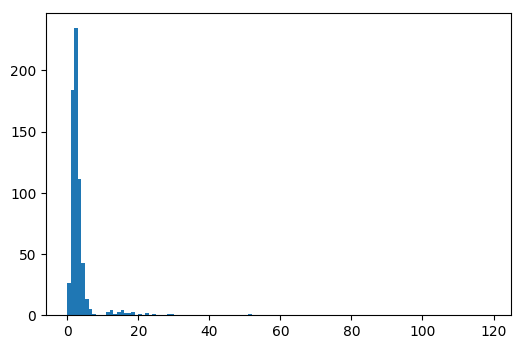

In [91]:
plt.hist((ratios_gd, ), bins=range(120));

In [ ]:
# bigger noise

In [78]:
ratios_gd = [11.508994023782094, 13.661234185693237, 6.9191490667147, 7.031860911487472, 4.861006845648829, 4.206066404701246, 8.042251557508854, 6.351334487602697, 7.809877802078297, 10.442018601334324, 6.103588929735959, 6.394133699633349, 12.553851202615677, 2.8162282107610848, 8.924746125934336, 13.812678794821318, 3.176093291908936, 1.3021840827412348, 7.410967522623412, 8.990512500034939, 5.79305342047835, 9.212381189509024, 6.33134645417285, 12.74297425934537, 8.606186305985233, 4.398511860001829, 3.251790340105412, 2.569074747884654, 7.633978978885102, 15.600196472131616, 4.266239437804007, 12.851157405623066, 9.160009965346816, 12.845449424913312, 23.053706617987878, 5.223385136323638, 8.074510608125596, 9.588393722882353, 7.345934453056105, 2.684760297701378, 4.364432323532804, 1.7635923470099302, 3.4719436024584844, 12.327352725678793, 7.208207748189116, 12.020527548043047, 2.8554548367858232, 7.290897001786398, 22.805077757757843, 25.244697502091853, 2.985506938302999, 7.505393388140298, 1.625477312856384, 4.290741702466915, 4.05287256846804, 9.210039747746155, 2.0814617741452635, 8.810867482674713, 1.9135946358240878, 9.120454932080106, 2.2357959154521216, 5.306783384884542, 15.357742625030989, 7.373515485755953, 1.1020956894832146, 9.759908214061172, 5.19142402852579, 12.95585988021091, 16.185146366050517, 8.566701459011144, 10.218478027673665, 2.7641965486361513, 6.602433465829196, 8.99877749589391, 10.168340520845971, 16.05855024775131, 3.288203215615747, 5.83641411412416, 6.123321277249367, 4.84506115329365, 8.803109053919648, 3.4839517406811873, 6.350470846953855, 10.841204001899683, 9.960552118010535, 8.613004325180226, 5.239714073454951, 23.312612676089792, 4.855886147815323, 1.343273445053057, 5.810193486371995, 12.45106875449522, 16.824835244691585, 8.692669870026965, 5.814555507193627, 2.5820931950994224, 5.490960051310646, 5.9947339445749375, 5.471923420190164, 7.955212206679885, 14.146173081428852, 7.619047283743163, 3.4817814095952055, 3.999096206787158, 10.82022124463323, 5.990723630827473, 11.308425328944491, 4.040819564622537, 6.354649749985222, 4.408616955550881, 9.159711138764466, 9.594749879001041, 8.684174438106451, 6.232195066186283, 3.8066314594007347, 17.487162643962048, 23.422064304045715, 4.1375428665573954, 13.67824722361162, 5.577424629183517, 14.365532279282668, 5.564124057170001, 8.927469744885322, 8.191388925979496, 8.773751663377716, 6.4302239116597955, 8.58271240583283, 13.638948593151435, 7.857924851701833, 2.5489230952341813, 14.079512159412916, 13.788632862042789, 19.241211695369397, 7.641957525521435, 3.242451537638729, 8.238050067344743, 3.2411124473754267, 13.420339731858833, 7.125518688700466, 6.720022677428216, 12.429191625813617, 9.614571998431238, 13.399207688940047, 7.2716011658013615, 9.186760818243199, 8.015932851418713, 1.476562756715002, 4.767046088986925, 8.207222298627574, 11.953077930793066, 4.547971381647606, 10.45552671958103, 2.2546635112811764, 11.638429855486171, 2.9410456424643594, 5.587636972679067, 4.113602439447997, 11.49630165926323, 2.0113536993788785, 6.41733363460719, 6.1232123360931245, 6.452680862236156, 7.132128512457984, 5.298490697661878, 4.438560128149192, 9.681233878451053, 12.752501329114445, 8.470107734209211, 2.790422933914918, 8.129733878408297, 6.25074491600644, 11.7646651389689, 6.730873162470252, 10.535348985291082, 14.559761946283595, 12.30708436585182, 6.1094687278340984, 5.042146112078669, 3.356417393155911, 4.4117146003030285, 5.030868094275934, 7.1167924135650384, 7.677356998494628, 23.78806048006595, 3.0501185423366715, 8.019881755678565, 11.771976441129492, 9.567125614829516, 15.454145971794555, 17.85754032628937, 3.7928801810770807, 4.662903300677604, 2.8489806588079847, 15.58493752822557, 10.060626506459082, 10.072731320799472, 6.29191568462202, 6.677729286907069, 5.663589084982827, 2.992921499334231, 11.417057773179042, 7.844078599319952, 1.7805620221867882, 1.0021023655829353, 3.521548707819713, 43.9432548685399, 4.048979615747492, 6.971346745657466, 4.469276948985876, 6.471851009706312, 6.2523080988243365, 4.234905112896302, 10.439938910808932, 10.609208957909255, 10.612665023891362, 6.783926715697904, 7.0111586488152895, 7.002051767960609, 4.611841862596289, 5.140230830770677, 1.5714858123378126, 10.484884806571468, 3.1248214716623854, 2.4548198996216164, 4.7139437807949225, 2.41068942819752, 4.035147380689175, 4.355215156639047, 16.31529712321908, 5.879927507383648, 4.74642408178524, 7.84471196912584, 9.674485591175346, 6.445401925796608, 4.5471868144307654, 14.120082240521874, 4.1364674027852875, 5.37903935582904, 7.827545463784795, 9.316078158030056, 1.0480477650050046, 9.337971045326226, 4.8512745408745275, 7.3459725114184975, 4.713746339132825, 7.2317222321664305, 20.70529423597756, 9.478824530444662, 5.878866015835134, 6.345770761827957, 3.4731766516826337, 6.103660563192159, 5.842357103751085, 14.679408228672703, 15.019036053761502, 11.143620048873245, 7.71192374905391, 15.022869725265467, 3.8573117662791, 17.99397930171794, 6.226341468489357, 2.131351140518456, 7.793047780640722, 6.722840662889405, 2.661308835251212, 5.866981884073758, 15.408656749219523, 4.114270323837616, 18.581800524391273, 4.699214812556974, 5.341567783689628, 15.216849005533344, 7.861716405682962, 18.955160031165242, 4.450272704539147, 1.9435067164362574, 12.590023848782907, 12.525897775443813, 11.61782906850422, 11.674053722594918, 6.182993861878942, 8.071157056686696, 7.306090736512473, 8.23507955655335, 4.208187040083564, 15.382941487435678, 16.145266958186465, 17.513019496140053, 2.3135247308463627, 11.798613899383392, 7.642672416737126, 7.246486496831052, 14.39790101529635, 9.637253881507915, 3.2593067806713245, 1.686861089230608, 12.979551675538817, 3.663941428876761, 2.331322527977173, 7.894681698865839, 12.441167110430742, 2.228289306404148, 12.103963288108778, 11.303179326521084, 12.197994686632661, 3.988455740387943, 6.349828025025497, 2.9434615482131257, 7.581424980434582, 5.6497618191856365, 7.553850108615367, 5.210985544969921, 3.8804209662194364, 20.919700357920618, 18.147279530003487, 8.29312319454896, 7.079140474853119, 42.801545029999595, 4.518434048966272, 2.8707651850829126, 15.166549948234026, 2.6304664607665855, 10.157911916061044, 2.869025569390744, 9.796901223175073, 8.54216968009311, 4.376637988508946, 8.060380521524321, 7.9108490877728705, 10.63003432993193, 2.9258180291603755, 6.85416298899187, 7.756734496003842, 12.664004036140431, 21.180506392111017, 6.802939971705873, 17.485992701054943, 5.4738538901253655, 10.418058059557321, 13.346273885183434, 1.8206929802591387, 3.374821643541091, 8.701045583556406, 16.869088856193958, 8.01725023912721, 12.20703336100313, 6.61656011967631, 9.869776591041179, 21.302904367416108, 14.230133786888214, 9.66039573563447, 8.422759444774112, 8.690262657420663, 5.388231819724113, 2.3523096926137144, 13.327801038711307, 6.422373629812058, 7.243340107023083, 7.019743832273765, 4.572012386197793, 13.686326900891103, 9.118290704966011, 6.073094643874099, 4.154653649487786, 7.546376975246842, 4.905633523622466, 5.735699392476906, 7.07566786204513, 2.825175788268377, 21.284981183797637, 4.229300116903603, 14.346468518363938, 12.32345877242066, 5.718591861601108, 10.39490911908853, 5.238841640125787, 7.645081527080753, 5.403682871663785, 4.966657167359792, 27.472375312068625, 17.309428054479504, 16.563980203667658, 5.133616880444476, 8.198896813658722, 14.878785689461077, 5.345701822264587, 9.317098494818627, 6.288495569373263, 6.834071967980605, 11.26256589253575, 6.587042085248177, 1.327760850126422, 6.243840408025296, 13.971439293510414, 2.8184705051311196, 4.021962495369713, 6.220824868362712, 13.095818720107157, 7.236743748137645, 2.280957440193042, 1.855898019592039, 20.724671028135944, 11.524907007949071, 12.007603026250573, 3.943382114665896, 21.56703696722902, 3.3993580416252076, 8.68385967850886, 5.2186500908132185, 2.7572456491791595, 24.321128263705965, 3.2730092695125705, 4.322250719148705, 10.329772941974882, 4.216465927453513, 12.866233001529965, 5.901922451012049, 1.7736189943384013, 5.450324998851331, 6.220041826757433, 3.657252779291112, 23.627536166073234, 8.937422510874912, 7.553097422271987, 7.147139004073768, 8.362501149706192, 6.867066852621514, 3.6756276076995342, 25.864682318544794, 12.721964280153669, 15.677429730041641, 3.523514615986421, 6.9164508470992745, 17.255028436548653, 2.2838004016881053, 5.222900096257782, 4.085436427287768, 10.578759663022883, 16.758768340453386, 4.671021857656467, 10.326277784865052, 11.37373585325738, 8.338177267037219, 10.226393610141205, 3.0463360800829014, 7.16786792798662, 14.90895542639178, 14.09458693449925, 2.0066169392307245, 8.344049354573333, 1.3275361001153354, 5.728911612517373, 3.2066503404273985, 10.744266345335463, 7.397117717687743, 4.25121886257135, 2.110431804884426, 8.659694794449209, 11.73936477154131, 1.308025314746044, 0.8968298314024388, 3.976856365257002, 25.404595167500084, 5.416184162122406, 12.610672617147648, 9.00918332937668, 12.835553857171103, 29.8352041074002, 2.5938119320059765, 3.886067173917822, 0.47205286965921955, 9.261760546324833, 2.108447364914278, 6.161852654811549, 9.445484158092441, 12.162638165238713, 7.097686462061797, 14.261044304304287, 1.8942767782171057, 8.347956443582657, 17.94367448531564, 6.71806383912904, 4.528177827463729, 10.654187622531765, 14.334846281833627, 7.34611867709345, 9.159803311911523, 10.96817790071649, 8.00680795084946, 9.370656008518562, 8.95375602735943, 9.65761513889144, 8.338701491885605, 4.011609015584777, 7.920870901776174, 5.077694441318266, 7.861011092692701, 6.825302273933791, 2.268210690308096, 17.441526583908637, ]

In [79]:
ratios_ds = [16.95537452066881, 21.229629185746262, 11.834353311172647, 12.722188165267317, 12.491583417949263, 9.76671402139572, 12.904317870850692, 14.763114870104687, 13.946544933079924, 14.445039550213446, 13.517217869621199, 11.490950964218953, 15.364060753166294, 13.936247581312966, 14.277802758035389, 38.37381678134291, 12.736870774115118, 12.14787709543238, 18.911764170720392, 13.819369450263162, 11.671550511826329, 11.541231730387073, 15.677593051840123, 21.311287208089105, 18.431468013231406, 13.15832242493343, 16.44846620338074, 13.341922634432922, 16.813982123365633, 37.92539345906342, 12.591592421510837, 40.04257452789976, 20.18385398557571, 33.62200596156596, 43.933350627080266, 13.649433546534638, 18.269305962741704, 18.80889295451758, 21.905450371203973, 12.019884956828104, 25.078397926397844, 11.855482072430329, 10.68937495774091, 23.934135992816703, 10.914318904075605, 17.781784751781277, 8.415932425611631, 12.211162112571323, 35.83763133836814, 31.92156755010759, 12.634561261001556, 13.091693677855305, 12.463262681131361, 19.45687396052045, 18.70546633767557, 15.649882440466767, 12.03181444618336, 34.66719494374472, 14.881856350989105, 12.800867670979443, 17.621195084107082, 20.154946381158947, 19.441676063722188, 16.736521425883673, 15.715656725036142, 14.815419051472277, 13.739967101139992, 13.45360750218644, 21.176095236351195, 21.402147355717666, 21.856916070239215, 13.001420384663161, 23.6281161117636, 20.168003450854094, 18.24184985595756, 23.67499509508697, 9.036366217908494, 15.626114783998252, 14.044203144789114, 24.626488032070945, 18.484544447907222, 10.224629103532532, 19.116128704961778, 18.08904207527158, 13.911553494508356, 10.313262702076223, 14.231481098145725, 28.211431591818055, 18.64084661985934, 11.707864868903936, 16.0076526810753, 17.773378343679575, 23.958413773270866, 27.39892654073724, 15.65126050456457, 18.058762881468297, 9.734837484628347, 11.346081247398432, 16.765904301335667, 18.383270768361328, 21.770056011516285, 15.39026134493478, 10.618537139515398, 12.147114111577917, 23.90263841445722, 9.639437419050417, 28.60944659875529, 11.977783883872092, 20.961644137858258, 10.089374924429581, 29.17928404533163, 25.112912082633823, 21.272110818218927, 11.653861567020327, 11.802918757145523, 24.973707112727023, 52.055960728123615, 14.29709266765938, 21.829671183711728, 30.700049249273604, 20.44572492179018, 15.929522129295743, 25.879372755421286, 16.179055021560718, 23.728945675152197, 21.044681342122857, 21.58591342895264, 28.63253500855883, 31.557426236391116, 18.641542026246682, 17.607095197674383, 34.12304299108032, 29.535821471050838, 11.106573395530267, 20.681072713592272, 28.049305784916573, 16.541414654293394, 14.936189132157908, 25.18660848268117, 17.749025830461793, 23.346867137341917, 15.676304584638363, 28.428779012453315, 11.45370361442482, 15.597443092655295, 16.606461781145022, 12.721487750901321, 13.063410751413063, 19.972305040024356, 24.7178240550917, 15.549758635065873, 17.681474217495303, 6.191603176229571, 24.929689600945114, 16.58294525431874, 11.922687047662757, 19.68630587794853, 24.968119509037294, 16.898788282549006, 20.58302992920604, 17.451324177710788, 12.074143801973282, 6.802141289558945, 8.637832183322578, 15.304214713111579, 26.414989508157294, 34.81100798109564, 32.83563830551502, 9.3155208132159, 29.735380761733303, 14.799551920622667, 18.14154685532102, 14.283388049335018, 24.550203025928802, 23.175053638357976, 15.766477325235194, 18.1362451360521, 27.346617617500332, 24.358041094424305, 12.293205338744496, 19.474655560830872, 25.576761068772623, 11.979597997261859, 40.990445531520024, 13.766187849386395, 27.546208087691948, 36.66691553362898, 17.608037808030076, 17.839213096188807, 42.82885200119363, 13.93860103159523, 28.241389618421067, 12.28852540164985, 21.984364092832134, 21.66246383834054, 18.32981259157865, 15.814170134719722, 12.943191598772373, 18.928025029911414, 10.332778893597476, 22.087703204626, 21.053339931194767, 7.400306652271218, 12.050928376811434, 14.171660022511675, 81.59099045590908, 10.881873681407761, 19.415900511587523, 9.798222108278752, 23.536310193255932, 16.245730852192978, 14.3473493670455, 20.55643080662544, 19.851947655978524, 18.331008324677605, 25.878702842909135, 25.85000421706481, 25.45931427254064, 7.411576195883654, 10.443148174853258, 13.942577178998551, 19.365983010717557, 14.321568225502189, 11.735983080720672, 13.967823105670185, 15.458534267327623, 9.469097621201156, 15.140861674048086, 23.484559801536946, 30.211278145781655, 14.506873116364764, 21.829293268515784, 20.39672107907728, 19.77925850610051, 8.174741770643594, 25.34643560000721, 27.583565070302303, 15.745209310566896, 25.900541514320487, 18.81518397055428, 8.667706868061344, 14.551201795076102, 12.655879215116002, 17.946365695877425, 20.207510389134125, 13.723051844298993, 27.486540897598903, 24.055422069777276, 10.785856990697676, 8.221010534553391, 17.361236652275068, 10.52392653677438, 10.895956269238045, 21.31705419072726, 22.608545665313795, 23.76933629233797, 15.131996576164974, 20.985230359073103, 13.785710241672032, 20.605498396832555, 10.454358565951614, 11.712429911776438, 18.260236948824197, 14.794476898088131, 12.027898422674014, 13.840081039739438, 22.937681784405704, 22.260374453036732, 41.35328763226042, 12.63180963549961, 9.518312535864109, 21.587374177615906, 15.55798017789715, 53.71787141274158, 14.89931964555868, 12.781261078694893, 26.756534367832984, 16.671650265830944, 20.727562798041557, 20.4320178684611, 18.58572263215419, 13.842319378803325, 25.23961422368476, 17.100406764490852, 13.56104364112019, 28.771348752126656, 20.988829565631214, 33.211203947744316, 7.815916697777617, 23.661095036445676, 13.232956488827842, 15.414657200552636, 24.522923352071555, 22.464586560967707, 10.093503374587629, 12.74567897853494, 22.15352545505784, 12.07174808472344, 7.374182357609897, 13.683138337445406, 16.881947651608247, 15.382861125952536, 21.30714667629711, 22.54655341402269, 18.79587871947191, 15.479782890271522, 17.452408218056075, 10.87469739898303, 18.514219318587223, 20.140120166799758, 15.962715839315104, 16.55664664231715, 15.415234072742969, 30.52838200077163, 32.06873388865028, 21.999643639667468, 19.95093966052451, 56.026619174351254, 8.666477426703667, 19.327136257038404, 32.2036573816369, 9.727059253678139, 23.596106994072432, 14.081629358147273, 23.58140433542548, 17.174758632971166, 21.565425697333822, 14.408070962970223, 15.792729617043767, 19.699013914461165, 16.18100354750174, 37.47816076174377, 26.000072458217804, 22.5112717558718, 68.30471554566502, 13.75497234626951, 36.26729550765461, 21.508387958066123, 21.796254833815585, 26.386235817868123, 9.997517196144944, 13.364240017600126, 24.253681665449687, 21.336293185326667, 21.10565164900646, 25.054878485435687, 15.405653392762627, 21.48556176119567, 35.30536418412553, 27.54627967114707, 19.020263853356845, 14.785125018224656, 18.207788217483298, 22.44366113926888, 9.996963377376963, 17.499721737825652, 23.158860338115616, 14.552623837054622, 20.70474847986247, 18.283385243127405, 14.56256317241276, 18.202021241162953, 15.512619363079223, 20.283644670688325, 21.689227810976842, 15.867174797894693, 18.05473868053527, 14.259030472065927, 11.851596276100553, 35.63838852554296, 13.29435300555897, 37.29062619827722, 16.096209103394113, 15.696534531376834, 17.95660543722224, 15.511956374769666, 14.35041747965788, 12.633981057654328, 13.570319792847906, 42.012800137012064, 23.510010561739566, 25.760767273457635, 22.410440281283243, 18.608202425233902, 38.17252458083503, 13.943927172418162, 20.9153479323772, 15.582182418275426, 13.713901245907953, 17.86814553929399, 18.948151932441558, 9.186477297728615, 14.885843701932886, 40.32364266275483, 14.597616047922608, 13.27833427493246, 16.51137865301595, 22.906736579149694, 19.642233198037385, 10.493650828373037, 15.823063884203124, 46.76440459658932, 15.903106820477888, 19.767673048671597, 14.841208016728588, 38.609503501706534, 15.971685592152939, 14.653165818904897, 18.278012726633605, 23.41182640996264, 53.62220918248898, 9.74465676418816, 20.31571033814541, 30.242558304619852, 17.845888692007836, 24.660874803622047, 12.504609185125364, 12.759905455446635, 13.895253171686807, 26.946309830306852, 11.527109020919664, 35.135778125494035, 19.708675896729442, 9.731644162519201, 12.632670871054087, 20.67991995513218, 16.32221596267643, 19.21512293729643, 49.566830093262375, 18.19044932506291, 35.841600460545564, 9.819373373612763, 20.864268530937828, 32.651061437064136, 10.019879249594972, 17.392241580309904, 12.392715347172581, 19.04467852962323, 33.526777326607544, 8.703739756749407, 19.42971779509459, 18.812159342615157, 16.27865003000341, 18.26157699814448, 13.105100352418717, 31.423178079099813, 30.98381806581218, 27.97262013225659, 14.447508736015044, 9.56665411200734, 14.641374750132316, 14.087808854312556, 13.403552596096029, 16.927625404388134, 12.484892278024123, 18.708640638422477, 11.987416790759813, 21.479722655058588, 31.626977964707404, 11.25939496792301, 10.233472787925535, 11.624723468909965, 36.55789281067868, 23.893833345554164, 27.059280799362345, 38.07363256866153, 32.885698146161275, 40.93285408893111, 15.659487212638123, 12.329358121484146, 14.498683446534315, 14.8163673925072, 14.48176447144497, 18.853540857433774, 16.878538574083706, 27.60305492761078, 19.0730972356757, 28.21312732264638, 16.06859848049158, 19.101547092276483, 19.113251356260022, 14.800134625355476, 17.16566041861265, 29.314326123615743, 42.854965228996505, 15.59619812419614, 23.75514987697547, 29.07822558712118, 18.40896981855304, 12.387833733864685, 14.298463380873367, 19.21011018854957, 15.56921081719875, 6.616798456959108, 16.036118938666746, 17.039019823540645, 22.617233307464808, 14.257778456771872, 13.325574199452777, 29.372641958748297, ]

### binary matrix

In [93]:
def create_binary_experiment(n, p, noise_s, S):
    X = np.random.choice((-1 / np.sqrt(n), 1 / np.sqrt(n)), n*p).reshape((n, p))

    # the real beta
    beta_true = np.zeros(p)
    random_indices = np.random.choice(range(p), replace=False, size=S)
    beta_true[random_indices] = (
        np.random.choice((-1, 1), size=S) * (1 + np.abs(np.random.normal(0, 1, S))))

    noise = np.random.normal(0, noise_s, n)

    # compute y from X and beta, return true beta
    y = X.dot(beta_true) + noise
    return X, y, beta_true

In [ ]:
n, p = 200, 1000
S = 10
noise_s = 0.33 * np.sqrt(S / n)
alpha = 0.1

In [ ]:
for S in [5, 10, 20, 50, 100, 150, 200]:
    # setup
    noise_s = 0.33 * np.sqrt(S / n)
    X, y, beta_true = create_binary_experiment(n, p, noise_s, S)
    
    t = time.time()
    # solve
    beta = solve_experiment(X, y, noise_s, t=100)
    beta_two = two_stage_solve(X, beta, noise_s, alpha)
    ratio_ds = error_ratio(beta, beta_true, noise_s)
    ratio_gd = error_ratio(beta_two, beta_true, noise_s)
    print("S={} ratio_ds={} ratio_gd={} seconds={}".format(S, ratio_ds, ratio_gd, int(time.time() - t)))

| S  | 5   | 10 | 20 | 50 | 100 | 150 | 200 |
|----|-----|----|----|----|-----|-----|-----|
| DS | 25  | 14 | 40 | 47 | 56  | 68  | 65  |
| GD | 0.3 | 3  | 3  | 36 | 52  | 68  | 71  |